<a href="https://colab.research.google.com/github/jcowart1987/Project2/blob/main/FIFAprojectipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Imports

In [4]:
## Pandas
import pandas as pd
## Numpy
import numpy as np
## MatplotLib
import matplotlib.pyplot as plt
## Seaborn
import seaborn as sns

## Preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import make_column_selector
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer

## Models
from sklearn.ensemble import AdaBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

## Classification Metrics
from sklearn.metrics import accuracy_score, recall_score, precision_score, \
f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, \
RocCurveDisplay

from sklearn import metrics

from sklearn.model_selection import GridSearchCV

## Import SMOTE
from imblearn.over_sampling import SMOTE
## Import special pipeline for smote
from imblearn.pipeline import make_pipeline as smote_pipe


## Set global scikit-learn configuration 
from sklearn import set_config
## Display estimators as a diagram
set_config(display='diagram') # 'text' or 'diagram'}

In [5]:
#Upload FIFA 22 data

df = pd.read_csv('/content/FifaPlayers22.csv')

In [6]:
df.head()

,overall,potential,value_eur,age,height_cm,weight_kg,club_team_id,league_level,club_position,work_rate,...,defending,attacking_finishing,skill_dribbling,skill_curve,movement_acceleration,movement_sprint_speed,power_shot_power,power_long_shots,mentality_aggression,defending_marking_awareness
0,93,93,78000000.0,34,170,72,73.0,1.0,RW,Medium/Low,...,34.0,95,96,93,91,80,86,94,44,20
1,92,92,119500000.0,32,185,81,21.0,1.0,ST,High/Medium,...,44.0,95,85,79,77,79,90,87,81,35
2,91,91,45000000.0,36,187,83,11.0,1.0,ST,High/Low,...,34.0,95,88,81,85,88,94,93,63,24
3,91,91,129000000.0,29,175,68,73.0,1.0,LW,High/Medium,...,37.0,83,95,88,93,89,80,81,63,35
4,91,91,125500000.0,30,181,70,10.0,1.0,RCM,High/High,...,64.0,82,88,85,76,76,91,91,76,68


In [7]:
#Make a copy of data in case of errors
ml_df = df.copy()

In [8]:
#Look for duplicates
df.duplicated().sum()

0

In [9]:
#Drop unecessary columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19239 entries, 0 to 19238
Data columns (total 25 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   overall                      19239 non-null  int64  
 1   potential                    19239 non-null  int64  
 2   value_eur                    19165 non-null  float64
 3   age                          19239 non-null  int64  
 4   height_cm                    19239 non-null  int64  
 5   weight_kg                    19239 non-null  int64  
 6   club_team_id                 19178 non-null  float64
 7   league_level                 19178 non-null  float64
 8   club_position                19178 non-null  object 
 9   work_rate                    19239 non-null  object 
 10  body_type                    19239 non-null  object 
 11  pace                         17107 non-null  float64
 12  shooting                     17107 non-null  float64
 13  passing         

In [10]:

#Drop club_team_id and league_level, since these are not player attributes or stats, and 
#likely don't affect salary
df.drop(columns='club_team_id', inplace=True)

In [11]:
df.drop(columns='league_level', inplace=True)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19239 entries, 0 to 19238
Data columns (total 23 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   overall                      19239 non-null  int64  
 1   potential                    19239 non-null  int64  
 2   value_eur                    19165 non-null  float64
 3   age                          19239 non-null  int64  
 4   height_cm                    19239 non-null  int64  
 5   weight_kg                    19239 non-null  int64  
 6   club_position                19178 non-null  object 
 7   work_rate                    19239 non-null  object 
 8   body_type                    19239 non-null  object 
 9   pace                         17107 non-null  float64
 10  shooting                     17107 non-null  float64
 11  passing                      17107 non-null  float64
 12  dribbling                    17107 non-null  float64
 13  defending       

For club position, I'm going to use "constant", instead of most_freq, because club position is unique, and salary changes drastically depending on position. I don't want a position that pays low (like wing defender), to be imputed as a position that pays high
(like attacker), since that would skew my data.

For all other missing data - those are statistics, so Im'going to use mean, since that won't likely skew data.

In [13]:
#Look for outliers
df.describe(include='all')

,overall,potential,value_eur,age,height_cm,weight_kg,club_position,work_rate,body_type,pace,...,defending,attacking_finishing,skill_dribbling,skill_curve,movement_acceleration,movement_sprint_speed,power_shot_power,power_long_shots,mentality_aggression,defending_marking_awareness
count,19239.000000,19239.000000,1.916500e+04,19239.000000,19239.000000,19239.000000,19178,19239,19239,17107.000000,...,17107.000000,19239.000000,19239.000000,19239.000000,19239.000000,19239.000000,19239.000000,19239.000000,19239.000000,19239.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN,29,9,10,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,SUB,Medium/Medium,Normal (170-185),NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,8299,10015,6685,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,65.772182,71.079370,2.850452e+06,25.210822,181.299704,74.943032,NaN,NaN,NaN,68.213071,...,51.703630,45.894433,55.660429,47.268933,64.652893,64.714902,57.776860,46.642705,55.538957,46.601746
std,6.880232,6.086213,7.613700e+06,4.748235,6.863179,7.069434,NaN,NaN,NaN,10.933155,...,16.189746,19.721023,18.784590,18.181085,15.167399,14.965426,13.192224,19.411583,16.972181,20.200807
min,47.000000,49.000000,9.000000e+03,16.000000,155.000000,49.000000,NaN,NaN,NaN,28.000000,...,14.000000,2.000000,4.000000,6.000000,14.000000,15.000000,20.000000,4.000000,10.000000,4.000000
25%,61.000000,67.000000,4.750000e+05,21.000000,176.000000,70.000000,NaN,NaN,NaN,62.000000,...,37.000000,30.000000,50.000000,35.000000,57.000000,58.000000,48.000000,32.000000,44.000000,29.000000
50%,66.000000,71.000000,9.750000e+05,25.000000,181.000000,75.000000,NaN,NaN,NaN,69.000000,...,56.000000,50.000000,61.000000,49.000000,67.000000,68.000000,59.000000,51.000000,58.000000,52.000000
75%,70.000000,75.000000,2.000000e+06,29.000000,186.000000,80.000000,NaN,NaN,NaN,76.000000,...,64.000000,62.000000,68.000000,61.000000,75.000000,75.000000,68.000000,62.000000,68.000000,63.000000


In [14]:
#There don't seem to be any outliers.

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19239 entries, 0 to 19238
Data columns (total 23 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   overall                      19239 non-null  int64  
 1   potential                    19239 non-null  int64  
 2   value_eur                    19165 non-null  float64
 3   age                          19239 non-null  int64  
 4   height_cm                    19239 non-null  int64  
 5   weight_kg                    19239 non-null  int64  
 6   club_position                19178 non-null  object 
 7   work_rate                    19239 non-null  object 
 8   body_type                    19239 non-null  object 
 9   pace                         17107 non-null  float64
 10  shooting                     17107 non-null  float64
 11  passing                      17107 non-null  float64
 12  dribbling                    17107 non-null  float64
 13  defending       

In [16]:
#Inspect for inconsistent values
print(df['age'].value_counts())
print(df['club_position'].value_counts())
print(df['work_rate'].value_counts())
print(df['body_type'].value_counts())


21    1547
22    1446
24    1442
25    1394
23    1387
20    1377
27    1200
26    1197
29    1178
28    1129
19    1099
30     901
31     825
18     733
32     634
33     468
34     354
17     271
35     258
36     146
37     105
38      62
39      39
16      20
40      14
41       7
43       3
42       2
54       1
Name: age, dtype: int64
SUB    8299
RES    3168
RCB     701
GK      701
LCB     701
RB      515
LB      515
ST      476
RCM     470
LCM     470
LM      410
RM      410
CAM     292
LDM     223
RDM     223
LS      223
RS      223
CB      186
RW      185
LW      185
CDM     168
RWB     116
LWB     116
CM       83
RF       35
LF       35
LAM      21
RAM      21
CF        7
Name: club_position, dtype: int64
Medium/Medium    10015
High/Medium       3661
Medium/High       1880
High/High         1099
Medium/Low         810
High/Low           808
Low/Medium         466
Low/High           455
Low/Low             45
Name: work_rate, dtype: int64
Normal (170-185)    6685
Normal (185+)

In [17]:
#There aren't any inconsistencies in my object data

#Create univariate visuals for featuers and target

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19239 entries, 0 to 19238
Data columns (total 23 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   overall                      19239 non-null  int64  
 1   potential                    19239 non-null  int64  
 2   value_eur                    19165 non-null  float64
 3   age                          19239 non-null  int64  
 4   height_cm                    19239 non-null  int64  
 5   weight_kg                    19239 non-null  int64  
 6   club_position                19178 non-null  object 
 7   work_rate                    19239 non-null  object 
 8   body_type                    19239 non-null  object 
 9   pace                         17107 non-null  float64
 10  shooting                     17107 non-null  float64
 11  passing                      17107 non-null  float64
 12  dribbling                    17107 non-null  float64
 13  defending       

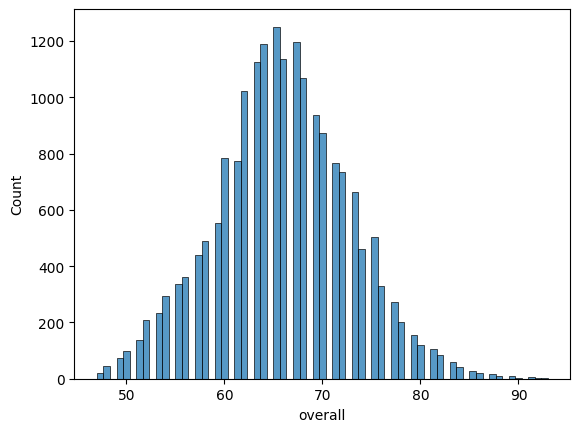

In [19]:
#Overall- create histogram
sns.histplot(data=df, x='overall');

The majority of the overall ratings of players is about 66.

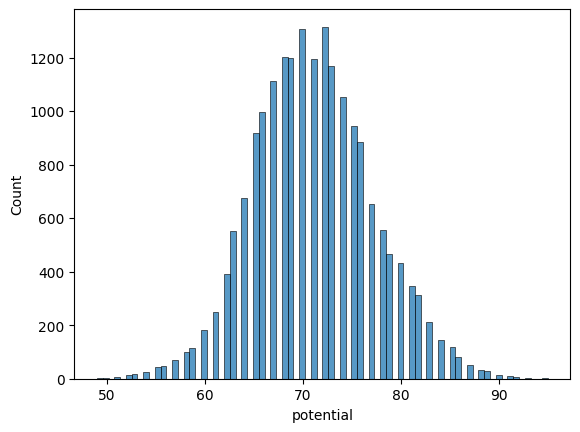

In [20]:
#Histogram for potential
sns.histplot(data=df, x='potential');

The potential of player talent lies mostly between 70-75

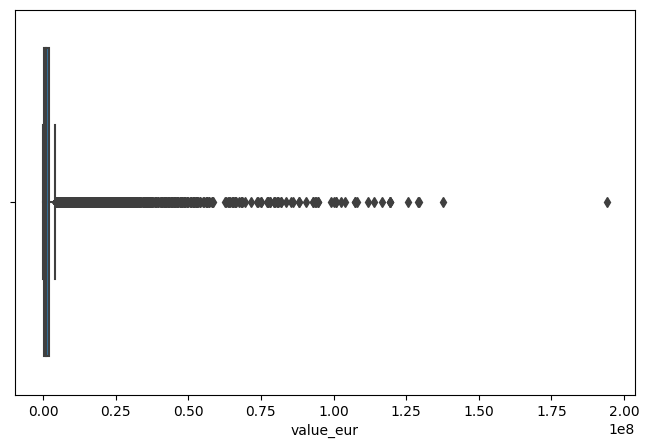

In [21]:
#Value in Euros - Target column
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8,5))
sns.boxplot(data=df, x='value_eur');

The majority of players earn in the 25th quartile of all salaries. There is one outlier player who earns 25% more than the rest of players. 

<Axes: xlabel='height_cm', ylabel='Count'>

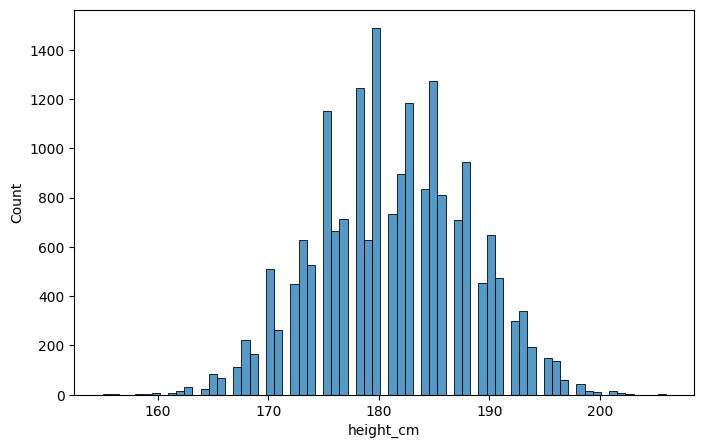

In [23]:
fig, axes = plt.subplots(figsize=(8,5))
sns.histplot(data=df, x='height_cm')

Most players are 180 centimeters tall.

<Axes: xlabel='weight_kg', ylabel='Count'>

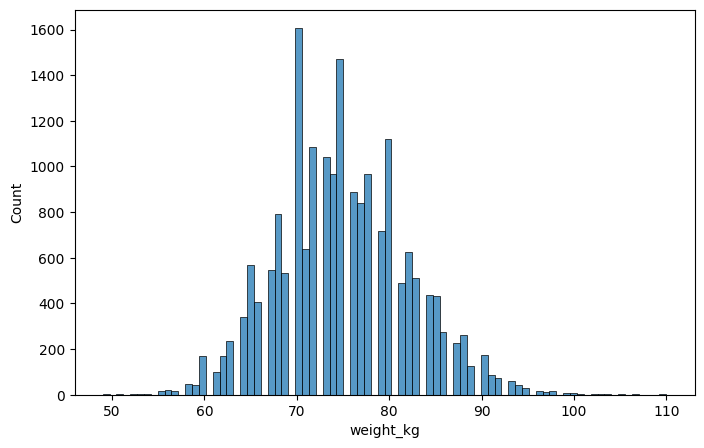

In [24]:
fig, axes = plt.subplots(figsize=(8,5))
sns.histplot(data=df, x='weight_kg')

Most players weigh between 70-75 kilograms.

<Axes: xlabel='club_position', ylabel='Count'>

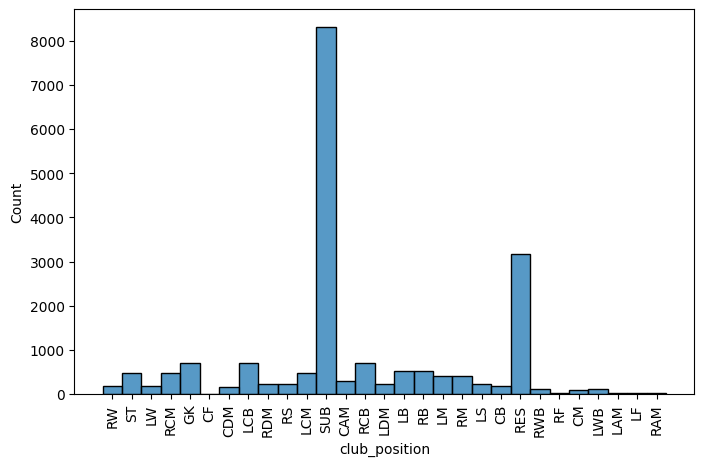

In [25]:
fig, axes = plt.subplots(figsize=(8,5))
plt.xticks(rotation='vertical')
sns.histplot(data=df, x='club_position')

The majority of players are substitutes. 

<Axes: xlabel='work_rate', ylabel='Count'>

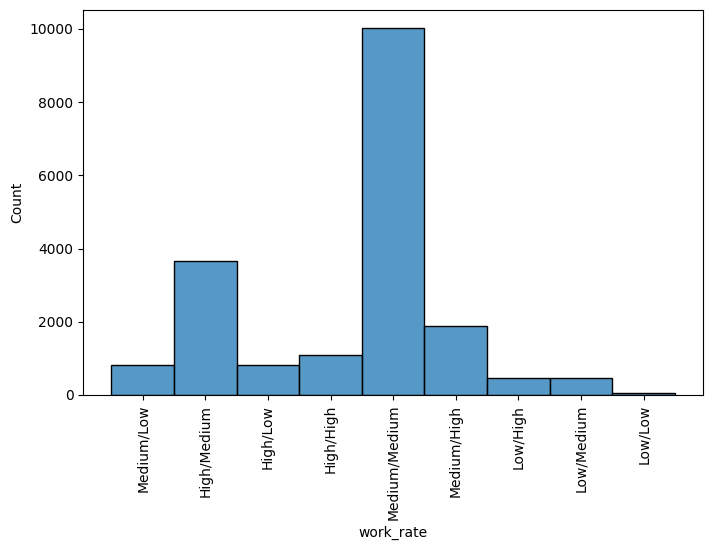

In [26]:
#Work rate
fig, axes = plt.subplots(figsize=(8,5))
plt.xticks(rotation='vertical')
sns.histplot(data=df, x='work_rate')

Most players' work rate is rated as "medium / medium".  

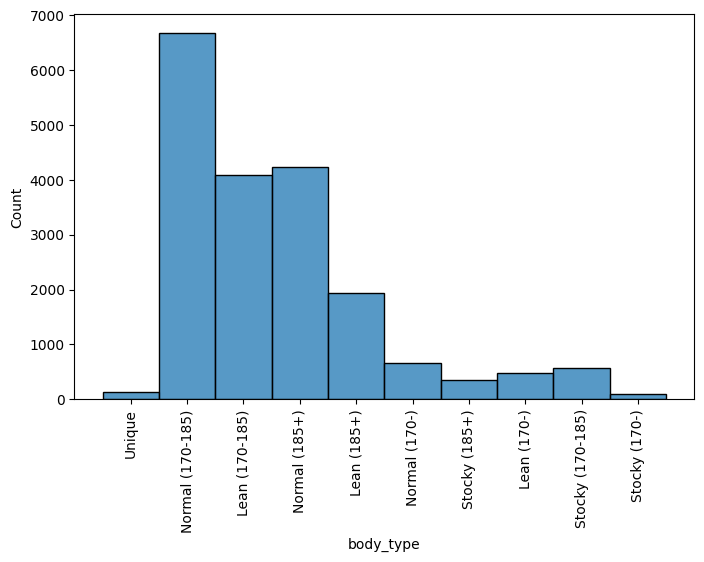

In [27]:
#Body Types
fig, axes = plt.subplots(figsize=(8,5))
plt.xticks(rotation='vertical')
sns.histplot(data=df, x='body_type');

Most body types are normal. The fewest body types are stocky. 

#Multivariate Exploration

Questions: 
1) What age players earn the most?
2) How much do established player make compared to younger, raw talent with high "potential." 
3) Out of shooting, passing, dribbling, and defending, which is valued more?

/usr/local/lib/python3.9/dist-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/usr/local/lib/python3.9/dist-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/usr/local/lib/python3.9/dist-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))


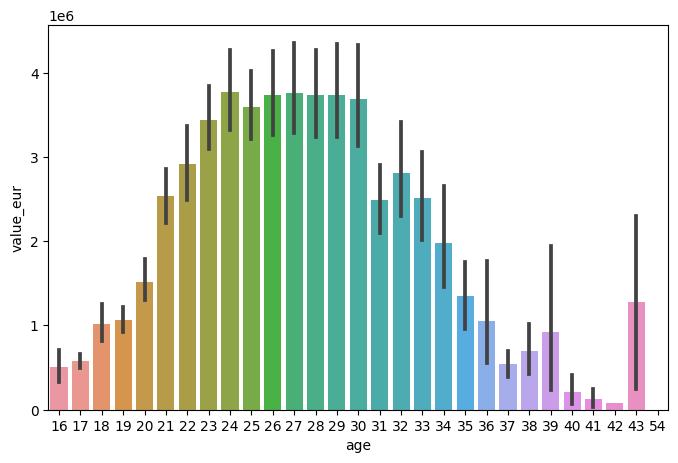

In [36]:
#Create visual about age distribution and how it correlates to salary.
fig, axes = plt.subplots(figsize=(8,5))
sns.barplot(data=df, x='age', y='value_eur');

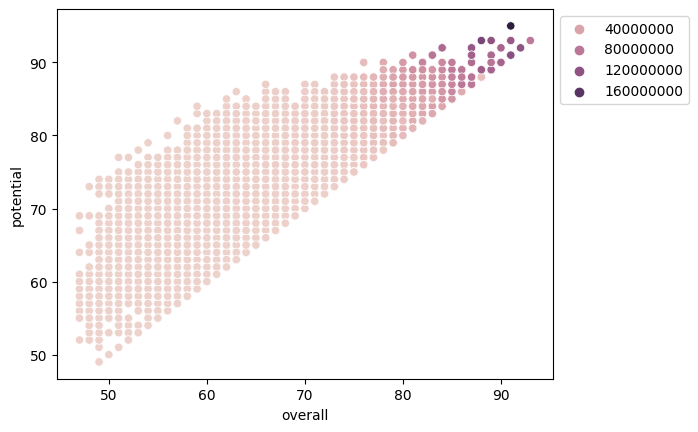

In [41]:
#Compare overall, potential, with salary
ax=sns.scatterplot(data=df, x='overall', y='potential', hue='value_eur')
ax.legend(bbox_to_anchor = (1,1));

Based on this scatter plot, we can deduce that clubs do not pay players for their "potential" (ie., young and upcoming superstars who haven't yet proven themselves). Unlike some American sports, like NFL and NBA, European footballers need to prove themselves and cannot rely on clubs to take a flier on them simply based off of promise.  

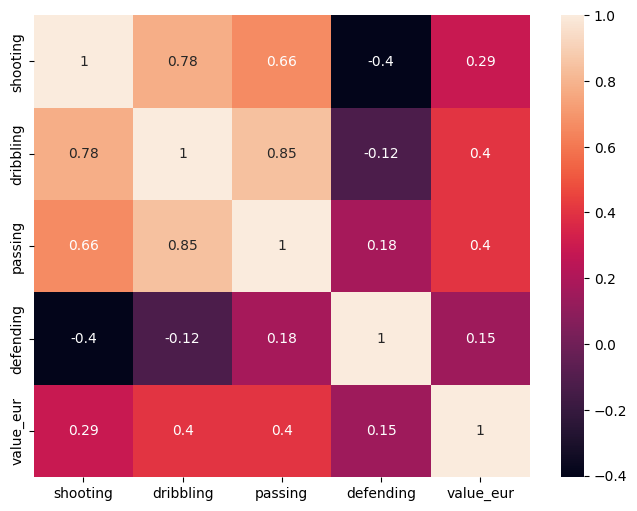

In [45]:
#Creat heatmap to see correlation between shooting, dribbling, passing, and defending to see if one is
#valued more than the other
cols_to_use1 = ['shooting', 'dribbling', 'passing', 'defending', 'value_eur']
heat_df = df[cols_to_use1]

fig,ax = plt.subplots(figsize=(8,6))
sns.heatmap(heat_df.corr(), annot=True, ax=ax);

Out of all of the top metrics used to describe a player, defending has the lowest correlation to amount of euros earned. Players with high passing and dribbling skills have a higher chance to earn more euros. 

Interestingly, players with high shooting ratings (ideally - your best shot takers) - have a fairly low correlation to high earnings.

#Key Finding #1 - Age Matters

/usr/local/lib/python3.9/dist-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/usr/local/lib/python3.9/dist-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))


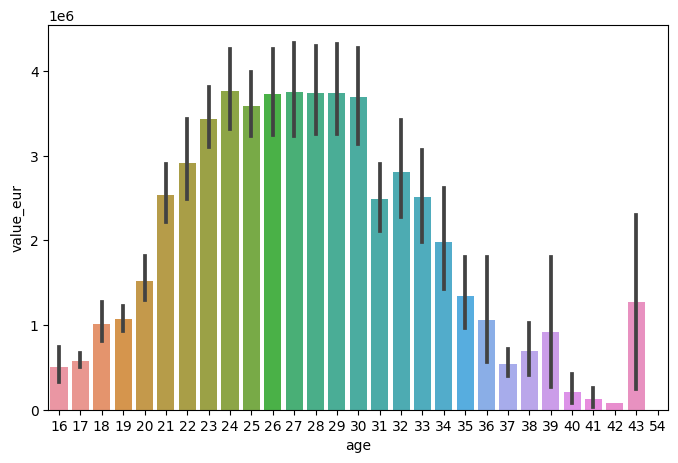

In [46]:
#Create visual about age distribution and how it correlates to salary.
fig, axes = plt.subplots(figsize=(8,5))
sns.barplot(data=df, x='age', y='value_eur');

This graph shows the age distribution related to how much each player earns. The top earners are between the ages of 24-30, with a steep drop off after 30 years old.  The youngest player in the data set is 16, and the oldest is 43.

#Key Finding #2 - You should practice your dribbling and passing skills 

/usr/local/lib/python3.9/dist-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/usr/local/lib/python3.9/dist-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/usr/local/lib/python3.9/dist-packages/numpy/lib/nanfunctions.py:1560: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a,
/usr/local/lib/python3.9/dist-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/usr/local/lib/python3.9/dist-packages/numpy/lib/nanfunctions.py:1560: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a,
/usr/local/lib/python3.9/dist-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/usr/local/lib/python3.9/dist-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.app

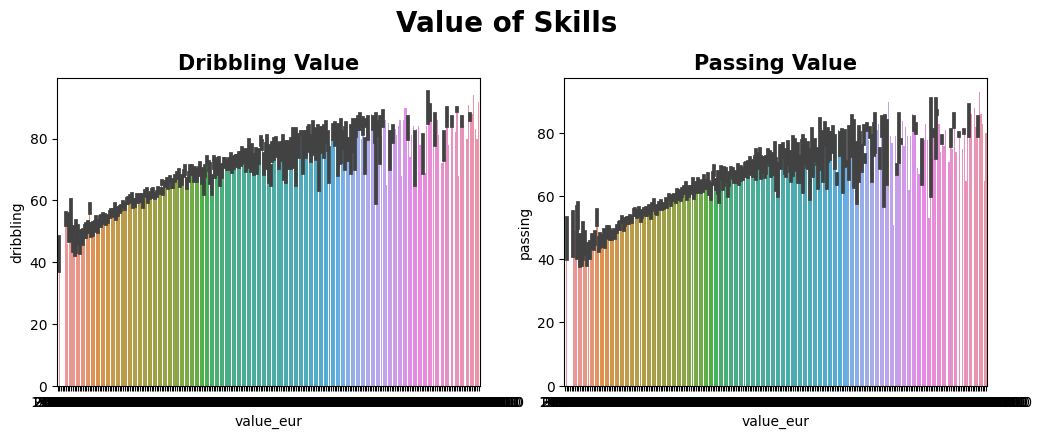

In [50]:

fig, axes = plt.subplots(ncols=2, figsize = (12,4))

sns.barplot(data=df, x='value_eur', y='dribbling', ax=axes[0])
axes[0].set_title('Dribbling Value', fontsize=15, fontweight = 'bold')

sns.barplot(data=df, x='value_eur', y='passing', ax=axes[1])
axes[1].set_title('Passing Value', fontsize=15, fontweight = 'bold')

fig.suptitle('Value of Skills', fontsize= 20, fontweight = 'bold', y=1.05);

There is a strong correlation between a player's dribbling skills, passing skills, and how much they earn. Moreso than other metrics, these are the top skills that clubs are looking for in players.

#Prepare data for machine learning

In [28]:
#Split the data
y = df['value_eur']
X = df.drop(columns='value_eur')

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

Impute missing values

In [29]:
scaler = StandardScaler()
ohe = OneHotEncoder(sparse_output = False, handle_unknown='ignore')

mean_imputer = SimpleImputer(strategy='mean')
constant_imputer = SimpleImputer(strategy = 'constant', fill_value='missing')


In [30]:
num_pipe = make_pipeline(mean_imputer, scaler)
cat_pipe = make_pipeline(constant_imputer, ohe)


In [31]:
cat_cols = make_column_selector(dtype_include='object')
num_cols = make_column_selector(dtype_include = 'number')

num_tuple = (num_pipe, num_cols)
cat_tuple = (cat_pipe, cat_cols)

In [32]:
preprocessor = make_column_transformer(num_tuple, cat_tuple, remainder='drop')

In [33]:
preprocessor.fit(X_train)

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f076ab9dac0>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='missing',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f076ac0cee0>)])

In [34]:
preprocessor.transform(X_train)
preprocessor.transform(X_test)

array([[-0.3994711 ,  0.31309138, -0.88401579, ...,  0.        ,
         0.        ,  0.        ],
       [-1.26764761, -0.83184593, -0.67368925, ...,  0.        ,
         0.        ,  0.        ],
       [-1.99112804,  0.64021633, -1.93564854, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.25477502, -1.15897088,  1.42957625, ...,  0.        ,
         1.        ,  0.        ],
       [-1.70173587, -0.50472099, -0.88401579, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.62627409,  2.11227858, -0.88401579, ...,  0.        ,
         0.        ,  0.        ]])